In [1]:
import os
os.chdir("../..")

In [2]:
%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
# from src.utils.echo_utils import get2dPucks ### We are using a debugging version!!
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [3]:
%matplotlib widget
from src.strain import *

# for get2dpucks
from skimage.transform import (resize, 
                               rescale)
from skimage.segmentation import find_boundaries
import copy

In [4]:
batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

In [5]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████| 16/16 [00:01<00:00, 13.08it/s]


In [6]:
model_save_path = "save_models/Original_Pretrained_R2plus1DMotionSegNet.pth"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


In [7]:
test_pat_index = 55

video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]

In [8]:
# let's try to use 9 pucks, if we divide into N=3 sections, we define each section to be 3 pucks
def get2dPucks(abin, apix, npucks=9):
    '''
    get2dPucks(abin, apix): Return the linear extent of the binary structure,
    as well as a sequence of radii about that extent.
    '''
    
    all_puck_endpoints = []
    
    # Empty bin?
    if ~np.any(abin):
        return 1.0, np.zeros((npucks,))
    
    x,y = np.where(abin>0)
    X = np.stack([x,y]) # Coords of all non-zero pixels., 2 x N
    if X.shape[1] < 1: # no pixels, doesn't seem to be a problem usually. 
        return (0.0, np.zeros((npucks,)))
    # Scale dimensions
    X = np.multiply(X, np.array(apix)[:, None]) # Need a broadcastable shape, here 2 x 1
    try:
        val, vec = np.linalg.eig(np.cov(X, rowvar=True))
    except:
        return (0.0, np.zeros((npucks,)))
    
    # Make sure we're in decreasing order of importance.
    eigorder = np.argsort(val)[-1::-1]
    vec = vec[:, eigorder]
    val = val[eigorder]

    
    # Negate the eigenvectors for consistency. Let's say y should be positive eig0,
    # and x should be positive for eig1. I'm not sure if that's what I'm doing here,
    # but just trying to be consistent.
    if vec[0,0] < 0:
        vec[:,0] = -1.0*vec[:,0]
    if vec[1,1] < 0:
        vec[:,1] = -1.0*vec[:,1]

    
    mu = np.expand_dims(np.mean(X, axis=1), axis=1)
    
    # Now mu is 2 x 1 mean pixel coord 
    # val is eigenvalues, vec is 2 x 2 right eigvectors (by column), all in matrix ij format
    
    # Use the boundary to get the radii.
    # Project the boundary pixel coords into the eigenspace.
    B = find_boundaries(abin, mode='thick')
    Xb = np.stack(np.where(B))
    Xb = np.multiply(Xb, np.array(apix)[:, None]) # space coords again.
    proj = np.dot((Xb-mu).T,vec) 
    # proj is M x 2, the projections onto 0 and 1 eigs of the M boundary coords.

    
    # Now get min max in the first principal direction. That's L! Just L[0] here.
    L_min, L_max = np.min(proj, axis=0), np.max(proj, axis=0)
    L = L_max - L_min

    
    # Partition along the principal axis. The secondary axis represents the radii.
    L_partition = np.linspace(L_min[0], L_max[0], npucks+1)

    
    R = []
    A = np.copy(proj)
    for i in range(len(L_partition)-1):
        # Select those boundary points whose projection on the major axis
        # is within the thresholds. 
        which = np.logical_and(A[:,0] >= L_partition[i],
                               A[:,0] < L_partition[i+1])
        # here which could be empty, if there are multiple components to the binary,
        # which will happen without cleaning for the largest connected component and 
        # such. r will be nan, here I replace with zero.
        # In fact, this math really only works well with nice convex objects.
        if len(which) == 0:
            r = 0
        else:
            r = np.median(np.abs(A[:,1][which]))
        R.append(r)

    # this plots all of the points of the individual lines of the npucks 
    for i in range(len(L_partition)-1):

        extent = (L_partition[i]+L_partition[i+1])/2
        points = np.array([mu + extent*vec[:,0, None] - R[i]*vec[:,1, None], # negative radius
                           mu + extent*vec[:,0, None] + R[i]*vec[:,1, None]]) # positive radius

        all_puck_endpoints.append(np.transpose(points))
                
    return L[0], np.array(R), np.array(all_puck_endpoints)

In [9]:
I = ed_label

length_I, radius_I, points_I = get2dPucks((I == 1).astype('int'), (1.0, 1.0))

In [10]:
I = give_boundary_no_basal_plane(ed_label)

In [11]:
N = 3
indeces_for_slice_points = []
for i in range(len(points_I)-1, 0, -N):
    indeces_for_slice_points.append(i)
indeces_for_slice_points.sort()
indeces_for_slice_points

[2, 5, 8]

In [12]:
slice_points = []

for i in indeces_for_slice_points:
    slice_points.append(points_I[i, 0, ...])
    
slice_points = np.array(slice_points)

In [13]:
lower_points = []

for i in range(slice_points.shape[0]):
    x = slice_points[i]
    i_1, i_2 = x[0][0], x[0][1]
    if i_1 > i_2:
        x = x[:, 0]
    else:
        x = x[:, 1]
    lower_points.append(x)
lower_points = np.array(lower_points)
print(lower_points.shape)

(3, 2)


In [14]:
lower_points = lower_points.astype('int')

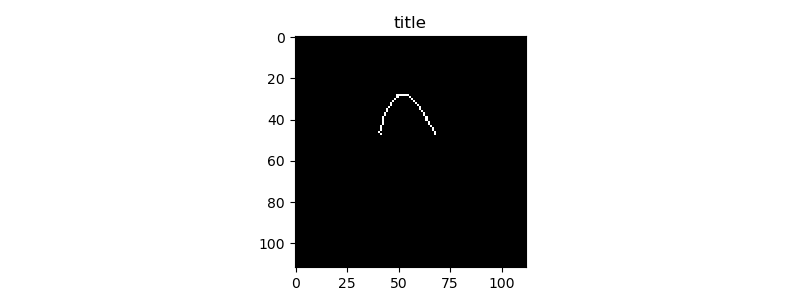

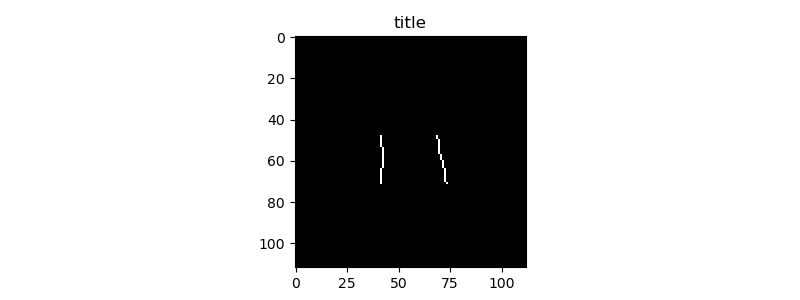

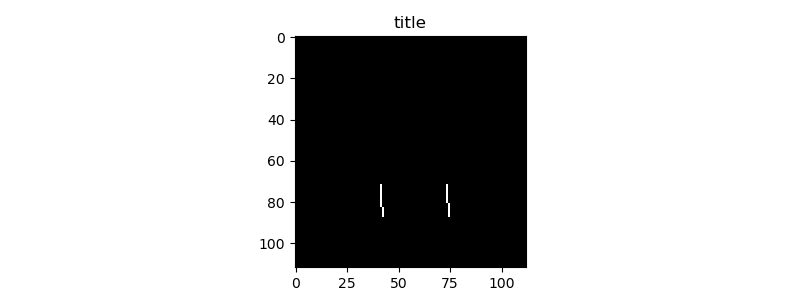

In [15]:
lower_points = np.insert(lower_points, 0, [0,0], axis=0)

import copy

I_regional_splits = [0 for i in range(N)]

for i in range(N):
    I_copy = copy.deepcopy(I)
    
    start = lower_points[i][0]
    end = lower_points[i+1][0]

    I_copy[0:start, 0:I_copy.shape[1]] = 0
    I_copy[end:I_copy.shape[0], 0:I_copy.shape[1]] = 0
    
    I_regional_splits[i] = I_copy
    
    vis_single(I_copy, cmap='gray')